# Natural Language Processing (some modern approaches)
Read this book for more details and codes (Dive into Deep Learning): https://d2l.ai/

+ Natural language processing (NLP) studies interactions between computers and humans using natural languages (usually text).
+ NLP is revolutionized by deep learning during recent years
+ Pre-processing is still a big chunk of NLP pipelines (e.g. normalizers, tokenizers, POS, etc.)
+ Classic NLP approaches focus on grammars and patterns while modern approaches focus on word representations and context 



## Representations (Embeddings)

A natural language is a complex system that we use to express meanings. In this system, words are the basic unit of linguistic meaning. As its name implies, **a word vector is a vector used to represent a word**. It can also be thought of as the **feature vector of a word**. The technique of mapping words to vectors of real numbers is also known as word embedding. Over the last few years, word embedding has gradually become basic knowledge in natural language processing.

To understand text, we can begin with its representation, such as treating each word or subword as an individual text token. The representation of each token can be pretrained on a large corpus, using word2vec or GloVe. After training, representation of each token can be a vector, however, it remains the same no matter what the context is. Thus, many more recent pretraining models adapt representation of the same token to different contexts. Among them is BERT, a much deeper model based on the Transformer encoder. 

### Why Not Use One-hot Vectors?

We could use one-hot vectors to represent words.
Recall that when we assume the number of different words in a
dictionary (the dictionary size) is $N$, each word can correspond one-to-one
with consecutive integers from 0 to $N-1$. These integers that correspond to
words are called the indices of the words.  We assume that the index of a word
is $i$. In order to get the one-hot vector representation of the word, we create
a vector of all 0s with a length of $N$ and set element $i$ to 1. In this way,
each word is represented as a vector of length $N$ that can be used directly by
the neural network.

Although one-hot word vectors are easy to construct, they are usually not a good choice in NLP. One of the major reasons is that the one-hot word vectors cannot accurately express the similarity between different words, such as the cosine similarity that we commonly use. For the vectors $\mathbf{x}, \mathbf{y} \in \mathbb{R}^d$, their cosine similarities are the cosines of the angles between them:

$$\cos(\alpha) = \frac{\mathbf{x}^\top \mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|} \in [-1, 1].$$

Since the cosine similarity between the one-hot vectors of any two different words is 0, it is difficult to use the one-hot vector to accurately represent the similarity between multiple different words.

![one-hot vs. w2c](one-hot.png)

### word2vec

[Word2vec](https://code.google.com/archive/p/word2vec/) provides an embedding for words that represents **each word with a
fixed-length vector** and uses these vectors to better indicate the **similarity and analogy** relationships between different words. The Word2vec [Mikolov, et. al, 2013] contains two models, **skip-gram** and **continuous bag of words (CBOW)**


#### The Skip-Gram Model

**The skip-gram model assumes that a word can be used to generate the words that surround it in a text sequence**. For example, we assume that the text sequence is "the", "man", "loves", "his", and "son". We use "loves" as the central target word and set the context window size to 2. **Given the central target word "loves", the skip-gram model is concerned with the conditional probability for generating the context words**, "the", "man", "his" and "son", that are within a distance of no more than 2 words, which is

$$P(\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}\mid\textrm{"loves"}).$$

We assume that, given the central target word, the context words are generated independently of each other. In this case, the formula above can be rewritten as

$$P(\textrm{"the"}\mid\textrm{"loves"})\cdot P(\textrm{"man"}\mid\textrm{"loves"})\cdot P(\textrm{"his"}\mid\textrm{"loves"})\cdot P(\textrm{"son"}\mid\textrm{"loves"}).$$

![The skip-gram model cares about the conditional probability of generating context words for a given central target word. ](skip-gram.svg)


In the skip-gram model, each word is represented as two $d$-dimension vectors, which are used to compute the conditional probability. We assume that the word is indexed as $i$ in the dictionary, its vector is represented as $\mathbf{v}_i\in\mathbb{R}^d$ when it is the central target word, and $\mathbf{u}_i\in\mathbb{R}^d$ when it is a context word.  Let the central target word $w_c$ and context word $w_o$ be indexed as $c$ and $o$ respectively in the dictionary. The conditional probability of generating the context word for the given central target word can be obtained by performing a softmax operation on the vector inner product:

$$P(w_o \mid w_c) = \frac{\text{exp}(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)},$$

where vocabulary index set $\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$. Assume that a text sequence of length $T$ is given, where the word at timestep $t$ is denoted as $w^{(t)}$. Assume that context words are independently generated given center words. When context window size is $m$, the likelihood function of the skip-gram model is the joint probability of generating all the context words given any center word

$$likelihood: \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),$$

Here, any timestep that is less than 1 or greater than $T$ can be ignored.

#### Skip-Gram training

**The skip-gram model parameters are the central target word vector and context word vector for each individual word**.  In the training process, we are going to learn the model parameters by maximizing the likelihood function, which is also known as maximum likelihood estimation. This is equivalent to minimizing the following loss function:

$$ - \sum_{t=1}^{T} \sum_{-m \leq j \leq m,\ j \neq 0} \text{log}\, P(w^{(t+j)} \mid w^{(t)}).$$


If we use the SGD, in each iteration we are going to pick a shorter subsequence through random sampling to compute the loss for that subsequence, and then compute the gradient to update the model parameters. The key of gradient computation is to compute the gradient of the logarithmic conditional probability for the central word vector and the context word vector. By definition, we first have


$$\log P(w_o \mid w_c) =
\mathbf{u}_o^\top \mathbf{v}_c - \log\left(\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)\right).$$

Through differentiation, we can get the gradient $\mathbf{v}_c$ from the formula above.

$$
\begin{aligned}
\frac{\partial \text{log}\, P(w_o \mid w_c)}{\partial \mathbf{v}_c}
&= \mathbf{u}_o - \frac{\sum_{j \in \mathcal{V}} \exp(\mathbf{u}_j^\top \mathbf{v}_c)\mathbf{u}_j}{\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}\\
&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} \left(\frac{\text{exp}(\mathbf{u}_j^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)}\right) \mathbf{u}_j\\
&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} P(w_j \mid w_c) \mathbf{u}_j.
\end{aligned}
$$

Its computation obtains the conditional probability for all the words in the dictionary given the central target word $w_c$. We then use the same method to obtain the gradients for other word vectors.



After the training, for any word in the dictionary with index $i$, we are going to get its two word vector sets $\mathbf{v}_i$ and $\mathbf{u}_i$.  **In applications of natural language processing, the central target word vector in the skip-gram model is generally used as the representation vector of a word**.

![w2v](w2c.png)


#### Negative Sampling

Negative sampling modifies the original objective function. Given a context window for the central target word $w_c$, we will treat it as an event for context word $w_o$ to appear in the context window and compute the probability of this event from

$$P(D=1\mid w_c, w_o) = \sigma(\mathbf{u}_o^\top \mathbf{v}_c),$$

Here, the $\sigma$ function has the same definition as the sigmoid activation function:

$$\sigma(x) = \frac{1}{1+\exp(-x)}.$$

**In fact, we treat it as a set of binary regression problems, to compute the prob. of a context word to be in the window and some negative samples (i.e. some randomely chosen context words that are not in the window).**


We will first consider training the word vector by maximizing the joint probability of all events in the text sequence. Given a text sequence of length $T$, we assume that the word at timestep $t$ is $w^{(t)}$ and the context window size is $m$. Now we consider maximizing the joint probability

$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(D=1\mid w^{(t)}, w^{(t+j)}).$$

However, the events included in the model only consider positive examples. In this case, only when all the word vectors are equal and their values approach infinity can the joint probability above be maximized to 1. Obviously, such word vectors are meaningless. Negative sampling makes the objective function more meaningful by sampling with an addition of negative examples. Assume that event $P$ occurs when context word $w_o$ appears in the context window of central target word $w_c$, and we sample $K$ words that do not appear in the context window according to the distribution $P(w)$ to act as noise words. We assume the event for noise word $w_k$($k=1, \ldots, K$) to not appear in the context window of central target word $w_c$ is $N_k$. Suppose that events $P$ and $N_1, \ldots, N_K$ for both positive and negative examples are independent of each other. By considering negative sampling, we can rewrite the joint probability above, which only considers the positive examples, as

$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),$$

Here, the conditional probability is approximated to be
$$ P(w^{(t+j)} \mid w^{(t)}) =P(D=1\mid w^{(t)}, w^{(t+j)})\prod_{k=1,\ w_k \sim P(w)}^K P(D=0\mid w^{(t)}, w_k).$$


Let the text sequence index of word $w^{(t)}$ at timestep $t$ be $i_t$ and $h_k$ for noise word $w_k$ in the dictionary. The logarithmic loss for the conditional probability above is

$$
\begin{aligned}
-\log P(w^{(t+j)} \mid w^{(t)})
=& -\log P(D=1\mid w^{(t)}, w^{(t+j)}) - \sum_{k=1,\ w_k \sim P(w)}^K \log P(D=0\mid w^{(t)}, w_k)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\left(1-\sigma\left(\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right)\right)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\sigma\left(-\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right).
\end{aligned}
$$

**In this formula, the first part is maximizing the prob. of having similar vector for words in the context window of the center word (i.e. sigmoid of word vectors dot product), and the second part is minimizing the prob. of having similar vector for the center word and words in the negative samples set.**

Here, **the gradient computation in each step of the training is no longer related to the dictionary size, but linearly related to $K$**. When $K$ takes a smaller constant, the negative sampling has a lower computational overhead for each step.



#### The Continuous Bag of Words (CBOW) Model

The continuous bag of words (CBOW) model is similar to the skip-gram model. **The biggest difference is that the CBOW model assumes that the central target word is generated based on the context words before and after it in the text sequence**. With the same text sequence "the", "man", "loves", "his" and "son", in which "loves" is the central target word, given a context window size of 2, the CBOW model is concerned with the conditional probability of generating the target word "loves" based on the context words "the", "man", "his" and "son", such as

$$P(\textrm{"loves"}\mid\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}).$$

![The CBOW model cares about the conditional probability of generating the central target word from given context words.  ](cbow.svg)

**Since there are multiple context words in the CBOW model, we will average their word vectors and then use the same method as the skip-gram model to compute the conditional probability**. We assume that $\mathbf{v_i}\in\mathbb{R}^d$ and $\mathbf{u_i}\in\mathbb{R}^d$ are the context word vector and central target word vector of the word with index $i$ in the dictionary (notice that the symbols are opposite to the ones in the skip-gram model). Let central target word $w_c$ be indexed as $c$, and context words $w_{o_1}, \ldots, w_{o_{2m}}$ be indexed as $o_1, \ldots, o_{2m}$ in the dictionary. Thus, the conditional probability of generating a central target word from the given context word is

$$P(w_c \mid w_{o_1}, \ldots, w_{o_{2m}}) = \frac{\text{exp}\left(\frac{1}{2m}\mathbf{u}_c^\top (\mathbf{v}_{o_1} + \ldots, + \mathbf{v}_{o_{2m}}) \right)}{ \sum_{i \in \mathcal{V}} \text{exp}\left(\frac{1}{2m}\mathbf{u}_i^\top (\mathbf{v}_{o_1} + \ldots, + \mathbf{v}_{o_{2m}}) \right)}.$$


For brevity, denote $\mathcal{W}_o= \{w_{o_1}, \ldots, w_{o_{2m}}\}$, and $\bar{\mathbf{v}}_o = \left(\mathbf{v}_{o_1} + \ldots, + \mathbf{v}_{o_{2m}} \right)/(2m)$. The equation above can be simplified as

$$P(w_c \mid \mathcal{W}_o) = \frac{\exp\left(\mathbf{u}_c^\top \bar{\mathbf{v}}_o\right)}{\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)}.$$

Given a text sequence of length $T$, we assume that the word at timestep $t$ is $w^{(t)}$, and the context window size is $m$.  The likelihood function of the CBOW model is the probability of generating any central target word from the context words.

$$ \prod_{t=1}^{T}  P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

#### CBOW training

CBOW model training is quite similar to skip-gram model training.  The maximum likelihood estimation of the CBOW model is equivalent to minimizing the loss function.

$$  -\sum_{t=1}^T  \text{log}\, P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

Notice that

$$\log\,P(w_c \mid \mathcal{W}_o) = \mathbf{u}_c^\top \bar{\mathbf{v}}_o - \log\,\left(\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)\right).$$

Through differentiation, we can compute the logarithm of the conditional probability of the gradient of any context word vector $\mathbf{v}_{o_i}$($i = 1, \ldots, 2m$) in the formula above.

$$\frac{\partial \log\, P(w_c \mid \mathcal{W}_o)}{\partial \mathbf{v}_{o_i}} = \frac{1}{2m} \left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} \frac{\exp(\mathbf{u}_j^\top \bar{\mathbf{v}}_o)\mathbf{u}_j}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \bar{\mathbf{v}}_o)} \right) = \frac{1}{2m}\left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} P(w_j \mid \mathcal{W}_o) \mathbf{u}_j \right).$$

We then use the same method to obtain the gradients for other word vectors. Unlike the skip-gram model, we usually use the context word vector as the representation vector for a word in the CBOW model.


### Training a small embedding
In this section, we will train a skip-gram model.

To insall d2l and Apache MXNet read: https://d2l.ai/chapter_installation/index.html#installing-mxnet-and-the-d2l-package

To learn more about MXNet, watch: https://www.youtube.com/watch?v=ay_pTOUcdcE

We use PTB dataset: https://corochann.com/penn-tree-bank-ptb-dataset-introduction-1456.html

In [2]:
import d2l
from mxnet import autograd, gluon, np, npx # Gluon is an API for mxnet; Autograd can automatically differentiate native Python and Numpy code.
from mxnet.gluon import nn
npx.set_np() # this is required to activate NumPy-like behaviors

batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words) # this function read the PTB data set and return the data loader.

The mxnet.np module aims to mimic NumPy. Most extra functionalities that enhance NumPy for deep learning use are available on other modules, such as npx for operators used in deep learning and autograd for automatic differentiation. The np module API is not complete. One notable change is GPU support.

In [22]:
len(vocab)

6719

##### Embedding Layer

The layer in which the obtained word is embedded is called the embedding layer, which can be obtained by creating an `nn.Embedding` instance in Gluon. The weight of the embedding layer is a matrix whose number of rows is the dictionary size (`input_dim`) and whose number of columns is the dimension of each word vector (`output_dim`). We set the dictionary size to $20$ and the word vector dimension to $4$.

In [4]:
embed = nn.Embedding(input_dim=20, output_dim=4) # This turns non-negative integers (indexes/tokens) into dense vectors of fixed size
embed.initialize()
embed.weight

Parameter embedding0_weight (shape=(20, 4), dtype=float32)

The input of the embedding layer is the index of the word. When we enter the index $i$ of a word, the embedding layer returns the $i^\mathrm{th}$ row of the weight matrix as its word vector. Below we enter an index of shape ($2$, $3$) into the embedding layer. Because the dimension of the word vector is 4, we obtain a word vector of shape ($2$, $3$, $4$).

In [5]:
x = np.array([[1, 2, 3], [4, 5, 6]])
embed(x)

array([[[ 0.01438687,  0.05011239,  0.00628365,  0.04861524],
        [-0.01068833,  0.01729892,  0.02042518, -0.01618656],
        [-0.00873779, -0.02834515,  0.05484822, -0.06206018]],

       [[ 0.06491279, -0.03182812, -0.01631819, -0.00312688],
        [ 0.0408415 ,  0.04370362,  0.00404529, -0.0028032 ],
        [ 0.00952624, -0.01501013,  0.05958354,  0.04705103]]])

##### Minibatch Multiplication

We can multiply the matrices in two minibatches one by one, by the minibatch multiplication operation `batch_dot`. Suppose the first batch contains $n$ matrices $\mathbf{X}_1, \ldots, \mathbf{X}_n$ with a shape of $a\times b$, and the second batch contains $n$ matrices $\mathbf{Y}_1, \ldots, \mathbf{Y}_n$ with a shape of $b\times c$. The output of matrix multiplication on these two batches are $n$ matrices $\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$ with a shape of $a\times c$. Therefore, given two `ndarray`s of shape ($n$, $a$, $b$) and ($n$, $b$, $c$), the shape of the minibatch multiplication output is ($n$, $a$, $c$).

In [6]:
X = np.ones((2, 1, 4))
Y = np.ones((2, 4, 6))
res = npx.batch_dot(X, Y)
res.shape

(2, 1, 6)

In forward calculation, the input of the skip-gram model contains the central target word index `center` and the concatenated context and noise word index `contexts_and_negatives`. In which, the `center` variable has the shape (batch size, 1), while the `contexts_and_negatives` variable has the shape (batch size, `max_len`). These two variables are first transformed from word indexes to word vectors by the word embedding layer, and then the output of shape (batch size, 1, `max_len`) is obtained by minibatch multiplication. Each element in the output is the inner product of the central target word vector and the context word vector or noise word vector.

In [7]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = npx.batch_dot(v, u.swapaxes(1, 2))
    return pred

In [8]:
# Verify that the output shape should be (batch size, 1, max_len).

skip_gram(np.ones((2, 1)), np.ones((2, 4)), embed, embed).shape #bacth size is 2

(2, 1, 4)

In [9]:
# Before training the word embedding model, we need to define the loss function of the model.
# According to the definition of the loss function in negative sampling, we can directly use Gluon's binary cross-entropy loss function SigmoidBinaryCrossEntropyLoss.
# read https://mxnet.apache.org/versions/1.8.0/api/python/docs/api/gluon/loss/index.html#mxnet.gluon.loss.SigmoidBinaryCrossEntropyLoss
# Other loss functions: https://mxnet.apache.org/versions/1.8.0/api/python/docs/api/gluon/loss/index.html

loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

It is worth mentioning that we can use the mask variable to specify the partial predicted value and label that participate in loss function calculation in the minibatch: when the mask is 1, the predicted value and label of the corresponding position will participate in the calculation of the loss function; When the mask is 0, the predicted value and label of the corresponding position do not participate in the calculation of the loss function. As we mentioned earlier, mask variables can be used to avoid the effect of padding on loss function calculations.

Given two identical examples, different masks lead to different loss values.

In [10]:
pred = np.array([[.5]*4]*2)
label = np.array([[1, 0, 1, 0]]*2)
mask = np.array([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask)

array([0.724077 , 0.3620385])

In [11]:
# We can normalize the loss in each example due to various lengths in each example.

loss(pred, label, mask) / mask.sum(axis=1) * mask.shape[1]

array([0.724077, 0.724077])

In [14]:
# Model
# We construct the embedding layers of the central and context words, respectively, 
# and set the hyperparameter word vector dimension embed_size to 100.

embed_size = 100
net = nn.Sequential() # Stacks Blocks sequentially
net.add(nn.Embedding(input_dim=len(vocab), output_dim=embed_size), # embedding layer of the central words
        nn.Embedding(input_dim=len(vocab), output_dim=embed_size)) # embedding layer of the context words

In [15]:
net.collect_params()

sequential0_ (
  Parameter embedding1_weight (shape=(6719, 100), dtype=float32)
  Parameter embedding2_weight (shape=(6719, 100), dtype=float32)
)

In [23]:
#Because of the existence of padding, the calculation of the loss function is slightly different

def train(net, data_iter, lr, num_epochs, ctx=d2l.try_gpu()): # data_iter: iterator of data, lr: learning rate, ctx: context
    net.initialize(ctx=ctx, force_reinit=True) # force re-initialization if parameter is already initialized.
    trainer = gluon.Trainer(net.collect_params(), 'adam',{'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        for i, batch in enumerate(data_iter):
            center, context_negative, mask, label = [data.as_in_ctx(ctx) for data in batch]
            
            # We’re ready for our first forward pass through the network, and we want autograd to record the computational graph 
            # so we can calculate gradients. 
            # One of the simplest ways to do this is by running the network (and loss) code in the scope of an autograd.record context.
            with autograd.record():
                pred = skip_gram(center, context_negative, net[0], net[1])
                l = (loss(pred.reshape(label.shape), label, mask)
                     / mask.sum(axis=1) * mask.shape[1])
            l.backward() # this is backward propagation on the context of autograd
            trainer.step(batch_size)
            metric.add(l.sum(), l.size)
            if (i+1) % 50 == 0:
                animator.add(epoch+(i+1)/len(data_iter),
                             (metric[0]/metric[1],))
    print('loss %.3f, %d tokens/sec on %s ' % (
        metric[0]/metric[1], metric[1]/timer.stop(), ctx))

loss 0.331, 4168 tokens/sec on cpu(0) 


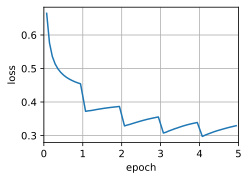

In [24]:
#Now, we can train a skip-gram model using negative sampling.

lr, num_epochs = 0.01, 5
train(net, data_iter, lr, num_epochs)

In [31]:
net[0].weight.data()[0] #the center vector for index 0 of the vocabulaty

array([-0.2751356 ,  0.14330375, -0.12779593, -0.16729437,  0.11583932,
        0.11139501, -0.2871355 ,  0.15574183,  0.0396573 ,  0.17784454,
        0.01620992,  0.14050531, -0.08152916,  0.02793214, -0.00704737,
        0.13305798, -0.07365568, -0.0104622 ,  0.09653691,  0.09107222,
        0.1466951 ,  0.22386375,  0.2797933 , -0.02330685,  0.05589831,
        0.09132888,  0.03969758, -0.04372361, -0.14111662,  0.06833752,
       -0.10715644,  0.09036028,  0.00519928, -0.04869202, -0.01841686,
       -0.22387779,  0.05958183, -0.07964647,  0.06420819,  0.35503784,
       -0.18577367, -0.32345837, -0.21449412,  0.10034329, -0.205499  ,
       -0.284399  , -0.03163657,  0.08266532, -0.06417808, -0.11823324,
       -0.23847148, -0.09274771, -0.23790532,  0.02505679, -0.18078332,
        0.05940418,  0.10776974,  0.06667179, -0.13584067, -0.1573786 ,
        0.26928732,  0.0501917 ,  0.00635963,  0.25432897,  0.16237807,
       -0.17512809,  0.17391114,  0.1556684 ,  0.11364204, -0.11

In [35]:
# Test trained model
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data()
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = np.dot(W, x) / np.sqrt(np.sum(W * W, axis=1) * np.sum(x * x) + 1e-9)
    topk = npx.topk(cos, k=k+1, ret_typ='indices').asnumpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print('cosine sim=%.3f: %s' % (cos[i], (vocab.idx_to_token[i])))

get_similar_tokens('plane', 10, net[0])

cosine sim=0.453: institutes
cosine sim=0.420: suggestion
cosine sim=0.416: battery
cosine sim=0.410: employs
cosine sim=0.397: army
cosine sim=0.391: headed
cosine sim=0.379: academy
cosine sim=0.378: replace
cosine sim=0.378: taxpayer
cosine sim=0.374: steelmaker


### Word Embedding with Global Vectors (GloVe)


Read the project page here: https://nlp.stanford.edu/projects/glove/

The main intuition underlying the model is the simple observation that ratios of **word-word co-occurrence probabilities** have the potential for encoding some form of meaning. In one round, it first computes co-occurance matrix based on the corpus and then tries to optimize an objective function to increase the chance of having similar vectors for closer words in the corpus. **The training objective of GloVe is to learn word vectors such that their dot product equals the logarithm of the words' probability of co-occurrence.**

We will continue the use of symbols from earlier in this section, $P(w_j \mid w_i)$ represents the conditional probability of generating context word $w_j$ with central target word $w_i$ in the dataset, and it will be recorded as $p_{ij}$. From a real example from a large corpus, here we have the following two sets of conditional probabilities with "ice" and "steam" as the central target words and the ratio between them:

|$w_k$=|“solid”|“gas”|“water”|“fashion”|
|--:|:-:|:-:|:-:|:-:|
|$p_1=P(w_k\mid$ "ice" $)$|0.00019|0.000066|0.003|0.000017|
|$p_2=P(w_k\mid$ "steam" $)$|0.000022|0.00078|0.0022|0.000018|
|$p_1/p_2$|8.9|0.085|1.36|0.96|

We will be able to observe phenomena such as:

* For a word $w_k$ that is related to "ice" but not to "steam", such as $w_k=$"solid", we would expect a larger conditional probability ratio, like the value 8.9 in the last row of the table above.
* For a word $w_k$ that is related to "steam" but not to "ice", such as $w_k=$"gas", we would expect a smaller conditional probability ratio, like the value 0.085 in the last row of the table above.
* For a word $w_k$ that is related to both "ice" and "steam", such as $w_k=$"water", we would expect a conditional probability ratio close to 1, like the value 1.36 in the last row of the table above.
* For a word $w_k$ that is related to neither "ice" or "steam", such as $w_k=$"fashion", we would expect a conditional probability ratio close to 1, like the value 0.96 in the last row of the table above.

We can see that the conditional probability ratio can represent the relationship between different words more intuitively. We can construct a word vector function to fit the conditional probability ratio more effectively. As we know, to obtain any ratio of this type requires three words $w_i$, $w_j$, and $w_k$. The conditional probability ratio with $w_i$ as the central target word is ${p_{ij}}/{p_{ik}}$. We can find a function that uses word vectors to fit this conditional probability ratio.

$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) \approx \frac{p_{ij}}{p_{ik}}.$$

The possible design of function $f$ here will not be unique. We only need to consider a more reasonable possibility. Notice that the conditional probability ratio is a scalar, we can limit $f$ to be a scalar function: $f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = f\left((\mathbf{u}_j - \mathbf{u}_k)^\top {\mathbf{v}}_i\right)$. After exchanging index $j$ with $k$, we will be able to see that function $f$ satisfies the condition $f(x)f(-x)=1$, so one possibility could be $f(x)=\exp(x)$. Thus:

$$f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = \frac{\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right)}{\exp\left(\mathbf{u}_k^\top {\mathbf{v}}_i\right)} \approx \frac{p_{ij}}{p_{ik}}.$$

One possibility that satisfies the right side of the approximation sign is $\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right) \approx \alpha p_{ij}$, where $\alpha$ is a constant. Considering that $p_{ij}=x_{ij}/x_i$, after taking the logarithm we get $\mathbf{u}_j^\top {\mathbf{v}}_i \approx \log\,\alpha + \log\,x_{ij} - \log\,x_i$. We use additional bias terms to fit $- \log\, \alpha + \log\, x_i$, such as the central target word bias term $b_i$ and context word bias term $c_j$:

$$\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j \approx \log(x_{ij}).$$

By taking the square error and weighting the left and right sides of the formula above, we can get the loss function of GloVe.


### Pre-trained models (transfer learning)
We've trained a word2vec word embedding model on a small-scale dataset and searched for synonyms using the cosine similarity of word vectors. In practice, word vectors pre-trained on a large-scale corpus can often be applied to downstream natural language processing tasks. In fact, we will experiment how to tranfer learning from one general domain to another.

MXNet's `contrib.text` package provides functions and classes related to natural language processing (see the GluonNLP tool package for more details). Next, let us check out names of the provided pre-trained word embeddings.

In [36]:
from mxnet import np, npx
from mxnet.contrib import text
npx.set_np()

text.embedding.get_pretrained_file_names().keys()

dict_keys(['glove', 'fasttext'])

In [37]:
print(text.embedding.get_pretrained_file_names('glove'))

['glove.42B.300d.txt', 'glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt', 'glove.840B.300d.txt', 'glove.twitter.27B.25d.txt', 'glove.twitter.27B.50d.txt', 'glove.twitter.27B.100d.txt', 'glove.twitter.27B.200d.txt']


In [39]:
# glove_6b50d = text.embedding.create('glove', pretrained_file_name='glove.6B.50d.txt') #This will download a pre-trained 
glove_6b300d = text.embedding.CustomEmbedding(pretrained_file_path='Pre-trained gloves-fa/glove300d.txt') # This glove is trained on Farsi Wikipedia
len(glove_6b300d)

49903

In [4]:
#We can use a word to get its index in the dictionary, or we can get the word from its index.
glove_6b300d.token_to_idx['تهران'], glove_6b300d.idx_to_token[3367]

(82, 'شهدای')

In [5]:
def knn(W, x, k):
    # W is the set of word vectors, x is the query vector, and k is the paramter for top_k selection
    # The added 1e-9 is for numerical stability
    cos = np.dot(W, x.reshape(-1,)) / (np.sqrt(np.sum(W * W, axis=1) + 1e-9) * np.sqrt((x * x).sum()))
    topk = npx.topk(cos, k=k, ret_typ='indices')
    return topk, [cos[int(i)] for i in topk]

In [6]:
def get_similar_tokens(query_token, k, embed):
    # By idx_to_vec we can obtain the vector representation for the words
    topk, cos = knn(embed.idx_to_vec,
                    embed.get_vecs_by_tokens([query_token]), k+1)
    for i, c in zip(topk[1:], cos[1:]):  # Remove input words
        print('cosine sim=%.3f: %s' % (c, (embed.idx_to_token[int(i)])))
    return topk

In [7]:
get_similar_tokens('تهران', 3, glove_6b300d)

cosine sim=0.636: مشهد
cosine sim=0.602: اصفهان
cosine sim=0.505: شهرداری


array([ 82., 716., 749., 986.])

#### Finding Analogies

In addition to seeking synonyms, we can also use the pre-trained word vector to seek the analogies between words. For example, “man”:“woman”::“son”:“daughter” is an example of analogy, “man” is to “woman” as “son” is to “daughter”. The problem of seeking analogies can be defined as follows: for four words in the analogical relationship $a : b :: c : d$, given the first three words, $a$, $b$ and $c$, we want to find $d$. Assume the word vector for the word $w$ is $\text{vec}(w)$. To solve the analogy problem, we need to find the word vector that is most similar to the result vector of $\text{vec}(c)+\text{vec}(b)-\text{vec}(a)$.

In [8]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed.get_vecs_by_tokens([token_a, token_b, token_c])
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 3)
    return embed.idx_to_token[int(topk[0])],embed.idx_to_token[int(topk[1])],embed.idx_to_token[int(topk[2])]  # Remove unknown words

In [9]:
get_analogy('زن','مرد','پسر',glove_6b300d)

('پسر', 'دختر', 'مرد')

In [10]:
get_analogy('پکن', 'چین', 'توکیو', glove_6b300d)

('ژاپن', 'توکیو', 'چین')

In [11]:
get_analogy('بد', 'بدتر', 'بزرگ', glove_6b300d)

('بزرگ', 'بزرگی', 'کوچک')

In [12]:
get_analogy('رفت', 'رفتن', 'خورد', glove_6b300d)

('خورد', 'بخورد', 'خوردن')

### Visualizing Word Vectors with t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. It is pretty useful when it comes to visualizing similarity between high-dimensional data. It works by taking a group of high-dimensional vocabulary word feature vectors, then compresses them down to 2-dimensional x,y coordinate pairs. The idea is to keep similar words close together on the plane, while maximizing the distance between dissimilar words.


It converts similarities between data points to joint probabilities and tries to minimize the Kullback–Leibler(KL) divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

t-SNE vs PCA: PCA is a linear dimension reduction technique that seeks to maximize variance and preserves large pairwise distances. In other words, things that are different end up far apart. This can lead to poor visualization especially when dealing with non-linear manifold structures.

For example, in the following toy example, considering only the two circled points, the dotted-line between the two circled-points represents what PCA focuses on, but what we might be interested in is the structure represented by the solid line. The length of the dotted-line is much shorter than the path along the solid-line which seems to be the true structure of the data here; PCA is penalizing incorrectly!

![](PCA_vs_t-SNE.png)

#### Use t-SNE in practice

In [43]:
from sklearn.manifold import TSNE

In [41]:
indices = get_similar_tokens('تهران', 100, glove_6b300d)
X = glove_6b300d.idx_to_vec[indices]
tokens = []
for i in indices:  # Remove input words
        tokens.append(glove_6b300d.idx_to_token[int(i)])
# tokens
# X
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

cosine sim=0.636: مشهد
cosine sim=0.602: اصفهان
cosine sim=0.505: شهرداری
cosine sim=0.496: دانشگاه
cosine sim=0.493: تبریز
cosine sim=0.488: شیراز
cosine sim=0.488: شد
cosine sim=0.487: شهر
cosine sim=0.485: اهواز
cosine sim=0.480: گفت
cosine sim=0.480: قم
cosine sim=0.475: ایران
cosine sim=0.473: لندن
cosine sim=0.472: قزوین
cosine sim=0.471: كلانشهر
cosine sim=0.465: کلانشهر
cosine sim=0.462: انتویر
cosine sim=0.458: كرج
cosine sim=0.451: جمعه
cosine sim=0.442: پاریس
cosine sim=0.442: نیز
cosine sim=0.441: اغاز
cosine sim=0.438: ادامه
cosine sim=0.435: پایان
cosine sim=0.435: مسکو
cosine sim=0.435: دانشجویان
cosine sim=0.434: ابیلای
cosine sim=0.434: برگزار
cosine sim=0.432: داد
cosine sim=0.431: همدان
cosine sim=0.430: استان
cosine sim=0.426: غرب
cosine sim=0.421: خبر
cosine sim=0.421: فلومیش
cosine sim=0.420: اسلامی
cosine sim=0.418: -
cosine sim=0.417: دیروز
cosine sim=0.417: هفته
cosine sim=0.415: شهردار
cosine sim=0.413: حضور
cosine sim=0.411: امروز
cosine sim=0.410: سوی
cosine

(101, 2)

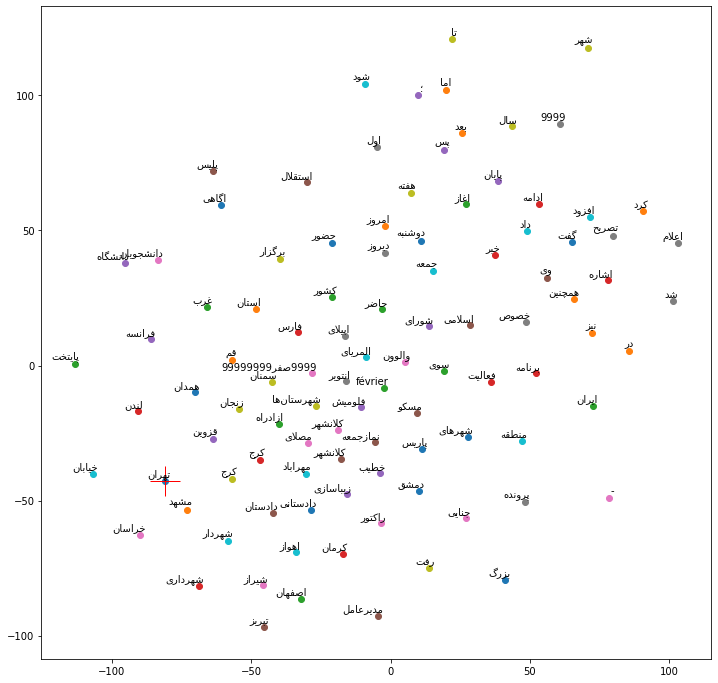

In [42]:
import matplotlib.pyplot as plt
from bidi import algorithm as bidialg #for rendering Farsi words in a continues format
import arabic_reshaper #for rendering Farsi words in a continues format
x = []
y = []
for value in X_embedded:
        x.append(value[0])
        y.append(value[1])

plt.figure(figsize=(12,12))
for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(bidialg.get_display(arabic_reshaper.reshape(tokens[i])),
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
plt.plot(x[0], y[0], "r+" , markersize=30)

plt.show()